In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/raf-db-dataset


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [8]:
import os

train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'  # путь к папке с датасетов

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Проверяем, что это папка
        num_images = len(os.listdir(class_path))
        print(f'Класс {class_name}: {num_images} изображений')

Класс 7: 2524 изображений
Класс 2: 281 изображений
Класс 5: 1982 изображений
Класс 3: 717 изображений
Класс 1: 1290 изображений
Класс 4: 4772 изображений
Класс 6: 705 изображений


Аугментация данных

In [9]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1
)

In [10]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224), # Размер изображения
    color_mode="rgb",# Чёрно-белые изображения
    batch_size=batch_size,  # Количество изображений в одном батче
    class_mode='categorical', # Многоклассовая классификация
    subset="training",  # Обучающий набор
    shuffle=True  # Перемешивание данных
)

val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",  # Валидационный набор
    shuffle=False
)

Found 11046 images belonging to 7 classes.
Found 1225 images belonging to 7 classes.


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop


from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D
batch_size = 64
base_model = DenseNet121(weights="imagenet", include_top=False,
                        input_shape=(224, 224, 3))

# Добавьте пользовательские слои классификации сверху
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=5,
    validation_data=val_set,
    validation_steps=val_set.samples // val_set.batch_size,
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,044,679 (26.87 MB)

 Trainable params: 6,961,031 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 453s 880ms/step - accuracy: 0.5056 - loss: 1.3772 - val_accuracy: 0.6562 - val_loss: 0.9136
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5312 - loss: 1.0346 - val_accuracy: 0.6842 - val_loss: 0.8874
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 182s 526ms/step - accuracy: 0.7439 - loss: 0.7203 - val_accuracy: 0.7640 - val_loss: 0.6761
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6250 - loss: 1.2719 - val_accuracy: 0.7533 - val_loss: 0.7046
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 202s 585ms/step - accuracy: 0.7983 - loss: 0.5556 - val_accuracy: 0.7697 - val_loss: 0.6439


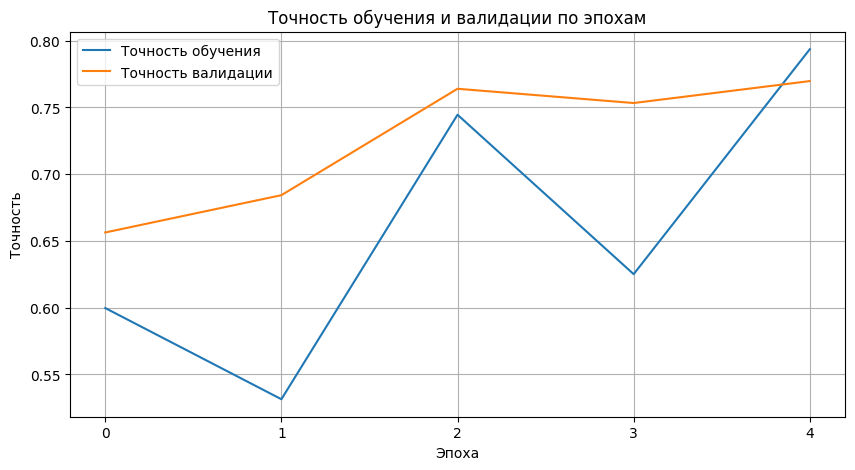

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Точность обучения')
    plt.plot(history.history['val_accuracy'], label='Точность валидации')
    plt.title('Точность обучения и валидации по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

Тюнинг модели
добавлен
полносвязный слой  для карты признаков
Dropout для предотвращения переобучения
изменен batch_size и количество епох

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop


from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D

base_model = DenseNet121(weights="imagenet", include_top=False,
                        input_shape=(224, 224, 3))
batch_size = 32
# Добавьте пользовательские слои классификации сверху
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Обратные вызовы для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,703 (27.85 MB)

 Trainable params: 264,199 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Обратные вызовы для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=15,
    validation_data=val_set,
    validation_steps=val_set.samples // val_set.batch_size,
    callbacks=callbacks
)

Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 475s 949ms/step - accuracy: 0.4246 - loss: 1.6164 - val_accuracy: 0.6595 - val_loss: 0.9602 - learning_rate: 1.0000e-04
Epoch 2/15
  1/345 ━━━━━━━━━━━━━━━━━━━━ 2:00 351ms/step - accuracy: 0.6250 - loss: 1.0427

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.6250 - loss: 1.0427 - val_accuracy: 0.6727 - val_loss: 0.9459 - learning_rate: 1.0000e-04
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 204s 591ms/step - accuracy: 0.6690 - loss: 0.9737 - val_accuracy: 0.7410 - val_loss: 0.7751 - learning_rate: 1.0000e-04
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.7812 - loss: 0.7986 - val_accuracy: 0.7220 - val_loss: 0.7832 - learning_rate: 1.0000e-04
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 245s 592ms/step - accuracy: 0.7453 - loss: 0.7334 - val_accuracy: 0.7426 - val_loss: 0.7248 - learning_rate: 1.0000e-04
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8125 - loss: 0.5124 - val_accuracy: 0.7319 - val_loss: 0.7207 - learning_rate: 1.0000e-04
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 237s 577ms/step - accuracy: 0.7796 - loss: 0.6313 - val_accuracy: 0.7492 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - a

In [ ]:
model.save("DenseNet121.keras")

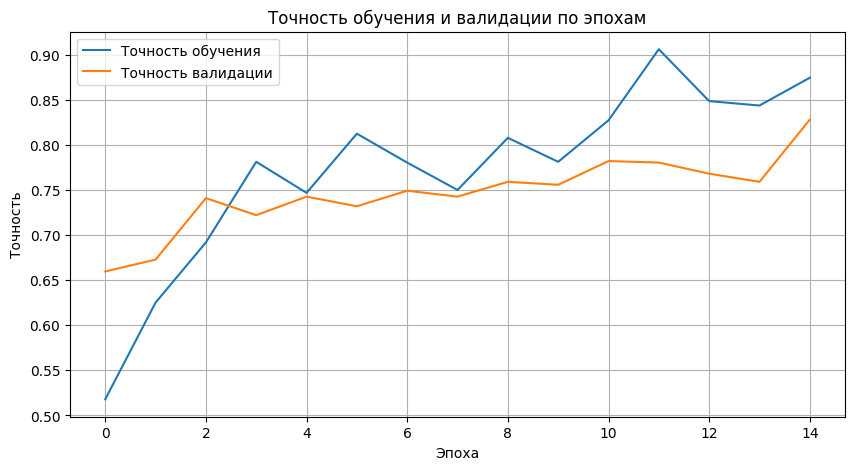

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Точность обучения')
    plt.plot(history.history['val_accuracy'], label='Точность валидации')
    plt.title('Точность обучения и валидации по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

In [18]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os

data = '/kaggle/input/raf-db-dataset/DATASET/train'
model = load_model('DenseNet121.keras')

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


classes = ['Удивление', 'Страх', 'Отвращение', 'Счастливый', 'Грустно', 'Злой', 'Нейтрально']
folders = ['1', '2', '3', '4', '5', '6', '7']
folder_to_class = {name: i for i, name in enumerate(folders)}

correct = [0] * len(classes)
total = [0] * len(classes)

for folder in folders:
    true_class = folder_to_class[folder]
    folder_path = os.path.join(data, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = preprocess_image(img_path)

        pred = model.predict(img, verbose=0)
        predicted_class = np.argmax(pred)

        if predicted_class == true_class:
            correct[true_class] += 1
        total[true_class] += 1

print("Точность по классам:")
for i, class_name in enumerate(classes):
    if total[i] > 0:
        accuracy = (correct[i] / total[i]) * 100
        print(f"{class_name}: {accuracy:.2f}%")
    else:
        print(f"{class_name}: Нет данных")


Точность по классам:
Удивление: 90.93%
Страх: 56.58%
Отвращение: 84.80%
Счастливый: 96.88%
Грустно: 89.86%
Злой: 86.67%
Нейтрально: 92.79%
